<h2>畳み込みニューラルネットワーク(CNN; Convolutional neural network)</h2>
<p>ヒトの視覚のように画像認識を得意としている。<br>
画像を入力とした分類問題によく使われる</p>
<p>畳み込み層、プーリング層、全結合層がある</p>
<p>畳み込み層とプーリング層のコードをシンプルに保ち、実行速度を保つためのアルゴリズムである<b>im2col, col2im</b>がある</p>

<h3>im2colのアルゴリズム</h3>
<p>行列積として計算すると比較的シンプルなコードで行うことができる<br>
im2colは簡潔さと実行速度で優れており、ディープラーニング用のライブラリ、ChainerやCaffeでも使われている</p>

In [130]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [131]:
# シンプルなim2col
def im2col(image, flt_h, flt_w, out_h, out_w):
    img_h, img_w = image.shape #入力画像の高さ、幅
    
    cols = np.zeros((flt_h*flt_w, out_h*out_w))
    
    for h in range(out_h):
        h_lim = h + flt_h
        for w in range(out_w):
            w_lim = w + flt_w
            cols[:, h*out_w+w] = img[h:h_lim, w:w_lim].reshape(-1)
    
    return cols

In [132]:
img = np.array([[1, 2, 3, 4],
                [5, 6, 7, 8],
                [9, 10,11,12],
                [13,14,15,16]])
cols = im2col(img, 2, 2, 3, 3)
print(cols)

[[ 1.  2.  3.  5.  6.  7.  9. 10. 11.]
 [ 2.  3.  4.  6.  7.  8. 10. 11. 12.]
 [ 5.  6.  7.  9. 10. 11. 13. 14. 15.]
 [ 6.  7.  8. 10. 11. 12. 14. 15. 16.]]


<p>このままだと、out_h * out_w回ループしているので、出力画像のピクセル数だけNumPyの配列にアクセスする。<br>
そのため、サイズが大きいと実行速度が非常に遅くなる</p>
<p>アクセス回数を最小限にする必要がある</p>

In [133]:
def im2col(image, flt_h, flt_w, out_h, out_w):
    img_h, img_w = image.shape
    cols = np.zeros((flt_h, flt_w, out_h, out_w))
    
    for h in range(flt_h):
        h_lim = h + out_h
        for w in range(flt_w):
            w_lim = w + out_w
            cols[h, w, :, :] = img[h:h_lim, w:w_lim]
    cols = cols.reshape(flt_h * flt_w, out_h * out_w)
    
    return cols

In [134]:
img = np.array([[1, 2, 3, 4],
                [5, 6, 7, 8],
                [9, 10,11,12],
                [13,14,15,16]])
cols = im2col(img, 2, 2, 3, 3)
print(cols)

[[ 1.  2.  3.  5.  6.  7.  9. 10. 11.]
 [ 2.  3.  4.  6.  7.  8. 10. 11. 12.]
 [ 5.  6.  7.  9. 10. 11. 13. 14. 15.]
 [ 6.  7.  8. 10. 11. 12. 14. 15. 16.]]


<h3>im2colの実装 -im2colの実用化-</h3>

In [135]:
def im2col(images, flt_h, flt_w, out_h, out_w):
    #バッチサイズ、チャンネル数、入力画像高さ、幅
    n_bt, n_ch, img_h, img_w = images.shape
    
    cols = np.zeros((n_bt, n_ch, flt_h, flt_w, out_h, out_w))
    
    for h in range(flt_h):
        h_lim = h + out_h
        
        for w in range(flt_w):
            w_lim = w + out_w
            cols[:,:, h, w, :, :] = images[:, :, h:h_lim, w:w_lim]
            
    cols = cols.transpose(1, 2, 3, 0, 4, 5).reshape(
            n_ch*flt_h*flt_w, n_bt*out_h*out_w)
    return cols

In [136]:
# パディングとストライドを考慮する必要がある場合

def im2col(images, flt_h, flt_w, out_h, out_w, stride, pad):
    n_bt, n_ch, img_h, img_w = images.shape
    
    img_pad = np.pad(images, [(0, 0), (0,0), (pad, pad), (pad, pad)], "constant")
    cols = np.zeros((n_bt, n_ch, flt_h, flt_w, out_h, out_w))
    
    for h in range(flt_h):
        h_lim = h + stride*out_h
        for w in range(flt_w):
            w_lim = w + stride*out_w
            cols[:, :, h, w, :, :] = img_pad[:, :, h:h_lim:stride, w:w_lim:stride]
            
    cols = cols.transpose(1, 2, 3, 0, 4, 5).reshape(n_ch*flt_h*flt_w, n_bt*out_h*out_w)
    return cols

In [137]:
img = np.array([[[[1, 2, 3, 4],
                  [5, 6, 7, 8],
                  [9, 10,11,12],
                  [13,14,15,16]]]])
cols = im2col(img, 2, 2, 3, 3, 1, 0)
print(cols)

[[ 1.  2.  3.  5.  6.  7.  9. 10. 11.]
 [ 2.  3.  4.  6.  7.  8. 10. 11. 12.]
 [ 5.  6.  7.  9. 10. 11. 13. 14. 15.]
 [ 6.  7.  8. 10. 11. 12. 14. 15. 16.]]


<h3>col2imのアルゴリズム</h3>

In [138]:
def col2im(cols, img_shape, flt_h, flt_w, out_h, out_w, stride, pad):
    n_bt, n_ch, img_h, img_w = img_shape
    
    cols = cols.reshape(n_ch, flt_h, flt_w, n_bt, out_h, out_w, ).transpose(3, 0, 1, 2, 4, 5)
    
    images = np.zeros((n_bt, n_ch, img_h + 2 * pad + stride - 1, img_w + 2 * pad + stride - 1))
    
    for h in range(flt_h):
        h_lim = h + stride * out_h
        for w in range(flt_h):
            w_lim = w + stride * out_w
            images[:, :, h:h_lim:stride, w:w_lim:stride] += cols[:, :, h, w, :, :]
    return images[:, :, pad:img_h+pad, pad:img_w+pad]

In [139]:
cols = np.ones((4, 4))
img_shape = (1, 1, 3, 3)
images = col2im(cols, img_shape, 2, 2, 2, 2, 1, 0)
print(images)

[[[[1. 2. 1.]
   [2. 4. 2.]
   [1. 2. 1.]]]]


<h2>畳み込み層の実装</h2>

In [140]:
class ConvLayer:
    # x_ch：入力チャンネル数、x_h：入力画像高さ、x_w：入力画像幅
    # n_flt：フィルタ数、flt_h：フィルタ高さ、flt_w：フィルタ幅
    # stride：ストライド幅、pad：パディング幅
    
    def __init__(self, x_ch, x_h, x_w, n_flt, flt_h, flt_w, stride, pad):
        # parameter
        self.params = (x_ch, x_h, x_w, n_flt, flt_h, flt_w, stride, pad)
        # filter and bias
        self.w = wb_width * np.random.randn(n_flt, x_ch, flt_h, flt_w)
        self.b = wb_width * np.random.randn(1, n_flt)
        
        #出力画像のサイズ
        self.y_ch = n_flt
        self.y_h = (x_h - flt_h + 2 * pad) // stride + 1
        self.y_w = (x_w - flt_w + 2 * pad) // stride + 1
        
        #AdaGrad用
        self.h_w = np.zeros((n_flt, x_ch, flt_h, flt_w)) + 1e-8
        self.h_b = np.zeros((1, n_flt)) + 1e-8
        
    #順伝播
    def forward(self, x):
        n_bt = x.shape[0]
        x_ch, x_h, x_w, n_flt, flt_h, flt_w, stride, pad = self.params
        
        y_ch, y_h, y_w =self.y_ch, self.y_h, self.y_w
        
        self.cols = im2col(x, flt_h, flt_w, y_h, y_w, stride, pad)
        self.w_col = self.w.reshape(n_flt, x_ch * flt_h * flt_w)
        
        #出力の計算：行列積、バイアスの加算、活性化関数
        u = np.dot(self.w_col, self.cols).T + self.b
        self.u = u.reshape(n_bt, y_h, y_w, y_ch).transpose(0, 3, 1, 2)
        self.y = np.where(self.u <= 0, 0, self.u)
        
    #逆伝播
    def backward(self, grad_y):
        n_bt = grad_y.shape[0]
        x_ch, x_h, x_w, n_flt, flt_h, flt_w, stride, pad = self.params
        
        y_ch, y_h, y_w = self.y_ch, self.y_h, self.y_w
        
        #delta
        delta = grad_y * np.where(self.u <= 0, 0, 1)
        delta = delta.transpose(0, 2, 3, 1).reshape(n_bt*y_h*y_w, y_ch)
        
        # gradient of filter and bias
        grad_w = np.dot(self.cols, delta)
        self.grad_w = grad_w.T.reshape(n_flt, x_ch, flt_h, flt_w)
        self.grad_b = np.sum(delta, axis=0)
        
        # gradient of input value
        grad_cols = np.dot(delta, self.w_col)
        x_shape = (n_bt, x_ch, x_h, x_w)
        self.grad_x = col2im(grad_cols.T, x_shape, flt_h, flt_w, y_h, y_w, stride, pad)
        
    def update(self, eta):
        self.h_w += self.grad_w * self.grad_w
        self.w -= eta / np.sqrt(self.h_w) * self.grad_w
        
        self.h_b += self.grad_b * self.grad_b
        self.b -= eta / np.sqrt(self.h_b) * self.grad_b

<h2>プーリング層の実装</h2>

In [141]:
class PoolingLayer:
    # x_ch：入力チャンネル数、x_h：入力画像高さ、x_w：入力画像幅
    # pool：プーリング領域のサイズ、pad：パディング幅
    
    def __init__(self, x_ch, x_h, x_w, pool, pad):
        # parameters
        self.params = (x_ch, x_h, x_w, pool, pad)
        
        self.y_ch = x_ch
        self.y_h = x_h//pool if x_h%pool==0 else x_h//pool+1 #出力高さ
        self.y_w = x_w//pool if x_w%pool==0 else x_w//pool+1 #出力幅
        
    #順伝播
    def forward(self, x):
        n_bt = x.shape[0]
        x_ch, x_h, x_w, pool, pad = self.params
        y_ch, y_h, y_w = self.y_ch, self.y_h, self.y_w
        
        # transform from input image to matrix
        cols = im2col(x, pool, pool, y_h, y_w, pool, pad)
        cols = cols.T.reshape(n_bt*y_h*y_w*x_ch, pool*pool)
        
        #calculation of output: MAX pooling
        y = np.max(cols, axis=1)
        self.y = y.reshape(n_bt, y_h, y_w, x_ch).transpose(0, 3, 1, 2)
        
        #save index of max value
        self.max_index = np.argmax(cols, axis=1)
        
    #逆伝播
    def backward(self, grad_y):
        n_bt = grad_y.shape[0]
        x_ch, x_h, x_w, pool, pad = self.params
        y_ch, y_h, y_w = self.y_ch, self.y_h, self.y_w
        
        # change axis of gradient of output
        grad_y = grad_y.transpose(0, 2, 3, 1)
        
        # create matrix
        grad_cols = np.zeros((pool*pool, grad_y.size))
        
        #change output gradient when the element is max value
        grad_cols[self.max_index.reshape(-1), np.arange(grad_y.size)] = grad_y.reshape(-1)
        grad_cols = grad_cols.reshape(pool, pool, n_bt, y_h, y_w, y_ch)
        grad_cols = grad_cols.transpose(5,0,1,2,3,4)
        grad_cols = grad_cols.reshape(y_ch*pool*pool, n_bt*y_h*y_w)
        
        # gradient of input
        x_shape = (n_bt, x_ch, x_h, x_w)
        self.grad_x = col2im(grad_cols, x_shape, pool, pool, y_h, y_w, pool, pad)

<h2>Base</h2>

In [142]:
class BaseLayer:
    def __init__(self, n_upper, n):
        self.w = wb_width * np.random.randn(n_upper, n)
        self.b = wb_width * np.random.randn(n)

        self.h_w = np.zeros(( n_upper, n)) + 1e-8
        self.h_b = np.zeros(n) + 1e-8
        
    def update(self, eta):
        self.h_w += self.grad_w * self.grad_w
        self.w -= eta / np.sqrt(self.h_w) * self.grad_w
        
        self.h_b += self.grad_b * self.grad_b
        self.b -= eta / np.sqrt(self.h_b) * self.grad_b

<h3>ドロップアウト</h3>

In [143]:
class Dropout:
    def __init__(self, dropout_ratio):
        self.dropout_ratio = dropout_ratio  # ニューロンを無効にする確率

    def forward(self, x, is_train):  # is_train: 学習時はTrue
        if is_train:
            rand = np.random.rand(*x.shape)  # 入力と同じ形状の乱数の行列
            self.dropout = np.where(rand > self.dropout_ratio, 1, 0)  # 1:有効 0:無効
            self.y = x * self.dropout  # ニューロンをランダムに無効化
        else:
            self.y = (1-self.dropout_ratio)*x  # テスト時は出力を下げる
        
    def backward(self, grad_y):
        self.grad_x = grad_y * self.dropout  # 無効なニューロンでは逆伝播しない


<h2>全結合層の実装</h2>

In [144]:
class MiddleLayer(BaseLayer):
    def forward(self, x):
        self.x = x
        self.u = np.dot(x, self.w) + self.b
        self.y = np.where(self.u <= 0, 0, self.u)
        
    def backward(self, grad_y):
        delta = grad_y * np.where(self.u <= 0, 0, 1)
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        
        self.grad_x = np.dot(delta, self.w.T)

In [145]:
class OutputLayer(BaseLayer):
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = np.exp(u)/np.sum(np.exp(u), axis=1).reshape(-1, 1)
    
    def backward(self, t):
        delta = self.y - t
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        
        self.grad_x = np.dot(delta, self.w.T)

<h2>畳み込みニューラルネットワークの実践</h2>

In [146]:
from sklearn import datasets

(1797, 64)


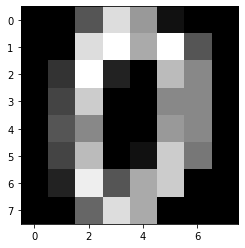

In [147]:
digits = datasets.load_digits()
print(digits.data.shape)

plt.imshow(digits.data[0].reshape(8, 8), cmap='gray')
plt.show()

In [148]:
print(digits.target.shape)
print(digits.target[:50])

(1797,)
[0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 9 5 5 6 5 0
 9 8 9 8 4 1 7 7 3 5 1 0 0]


In [149]:
# 手書き文字データセット読み込み
digits_data = datasets.load_digits()
input_data = digits_data.data
correct = digits_data.target
n_data = len(correct)

In [150]:
#入力値の標準化
ave_input = np.average(input_data)
std_input = np.std(input_data)
input_data = (input_data - ave_input) / std_input

In [151]:
#　正解をone-hot表現に
correct_data = np.zeros((n_data, 10))
for i in range(n_data):
    correct_data[i, correct[i]] = 1.0

In [152]:
# 訓練データとテストデータ
index = np.arange(n_data)
index_train = index[index%3 != 0]
index_test = index[index%3 == 0]

input_train = input_data[index_train, :]
correct_train = correct_data[index_train, :]
input_test = input_data[index_test, :]
correct_test = correct_data[index_test, :]

n_train = input_train.shape[0]
n_test = input_test.shape[0]

In [153]:
# setting values
img_h = 8
img_w = 8
img_ch = 1

wb_width = 0.1
eta = 0.01
epoch = 50
batch_size = 8
interval = 10
n_sample = 200 #誤差計測サンプル数

In [154]:
# さらに深いネットワーク
cl_1 = ConvLayer(img_ch, img_h, img_w, 10, 3, 3, 1, 1)
cl_2 = ConvLayer(cl_1.y_ch, cl_1.y_h, cl_1.y_w, 10, 3, 3, 1, 1)
pl_1 = PoolingLayer(cl_2.y_ch, cl_2.y_h, cl_2.y_w, 2, 0)

n_fc_in = pl_1.y_ch * pl_1.y_h * pl_1.y_w

ml_1 = MiddleLayer(n_fc_in, 200)
dr_1 = Dropout(0.5)

ml_2 = MiddleLayer(200, 200)
dr_2 = Dropout(0.5)

ol_1 = OutputLayer(200, 10)

In [155]:
#順伝播 深層
def forward_propagation(x, is_train):
    n_bt = x.shape[0]
    
    images = x.reshape(n_bt, img_ch, img_h, img_w)
    cl_1.forward(images)
    cl_2.forward(cl_1.y)
    pl_1.forward(cl_2.y)
    
    fc_input = pl_1.y.reshape(n_bt, -1)
    ml_1.forward(fc_input)
    dr_1.forward(ml_1.y, is_train)
    ml_2.forward(dr_1.y)
    dr_2.forward(ml_2.y, is_train)
    ol_1.forward(dr_2.y)

In [156]:
#逆伝播
def backpropagation(t):
    n_bt = t.shape[0]
    
    ol_1.backward(t)
    dr_2.backward(ol_1.grad_x)
    ml_2.backward(dr_2.grad_x)
    dr_1.backward(ml_2.grad_x)
    ml_1.backward(dr_1.grad_x)
    
    grad_img = ml_1.grad_x.reshape(n_bt, pl_1.y_ch, pl_1.y_h, pl_1.y_w)
    pl_1.backward(grad_img)
    cl_2.backward(pl_1.grad_x)
    cl_1.backward(cl_2.grad_x)

In [157]:
# 重みとバイアスの更新
def update_wb():
    cl_1.update(eta)
    ml_1.update(eta)
    ol_1.update(eta)

In [158]:
#交差エントロピー誤差を計算
def get_error(t, batch_size):
    return - np.sum(t * np.log(ol_1.y + 1e-7)) / batch_size

In [159]:
# サンプルを順伝播
def forward_sample(inp, correct, n_sample):
    index_rand = np.arange(len(correct))
    np.random.shuffle(index_rand)
    index_rand = index_rand[:n_sample]
    x = inp[index_rand, :]
    t = correct[index_rand, :]
    forward_propagation(x, False)
    return x, t

In [160]:
train_error_x = []
train_error_y = []
test_error_x = []
test_error_y = []

In [161]:
n_batch = n_train // batch_size

In [162]:
for i in range(epoch):
    x, t = forward_sample(input_train, correct_train, n_sample)
    error_train = get_error(t, n_sample)
    
    x, t = forward_sample(input_test, correct_test, n_sample)
    error_test = get_error(t, n_sample)
    
    train_error_x.append(i)
    train_error_y.append(error_train)
    test_error_x.append(i)
    test_error_y.append(error_test)
    
    # 経過表示
    if i%interval == 0:
        print('Epoch: ' + str(i) + '/' + str(epoch),
             'Error_train: ' + str(error_train),
             'Error_test: ' + str(error_test))
        
    # -- learning --
    index_rand = np.arange(n_train)
    np.random.shuffle(index_rand)
    for j in range(n_batch):
        mb_index = index_rand[j*batch_size : (j+1)*batch_size]
        x = input_train[mb_index, :]
        t = correct_train[mb_index, :]
        
        forward_propagation(x, True)
        backpropagation(t)
        update_wb()

Epoch: 0/50 Error_train: 2.3064276131587262 Error_test: 2.304601718299115
Epoch: 10/50 Error_train: 0.32070167143304196 Error_test: 0.37911159454717636
Epoch: 20/50 Error_train: 0.21470466367164534 Error_test: 0.25314986556297225
Epoch: 30/50 Error_train: 0.11406433492670091 Error_test: 0.19724339068345906
Epoch: 40/50 Error_train: 0.12742235192835896 Error_test: 0.16196195509883884


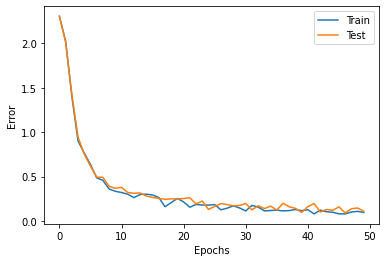

Accuracy Train:  97.91318864774624% Accuracy Test:  97.16193656093489%


In [163]:
# 誤差の記録をグラフ表示
plt.plot(train_error_x, train_error_y, label='Train')
plt.plot(test_error_x, test_error_y, label='Test')
plt.legend()

plt.xlabel('Epochs')
plt.ylabel('Error')

plt.show()

# --正解率の測定--
x, t = forward_sample(input_train, correct_train, n_train)
count_train = np.sum(np.argmax(ol_1.y, axis=1) == np.argmax(t, axis=1))

x, t = forward_sample(input_test, correct_test, n_test)
count_test = np.sum(np.argmax(ol_1.y, axis=1) == np.argmax(t, axis=1))

print('Accuracy Train: ', str(count_train/n_train*100) + '%',
      'Accuracy Test: ', str(count_test/n_test*100) + '%')